In [2]:
!pip install openai

from openai import OpenAI
import networkx as nx

import numpy as np
import pandas as pd

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import time

class Agent:
    def __init__(self, api_key, model, description=None, api_type="Groq", max_retries=5, retry_delay=50):
        self.client = OpenAI(api_key=api_key, base_url="https://openrouter.ai/api/v1")
        self.model = model
        self.description = description
        self.max_retries = max_retries
        self.retry_delay = retry_delay
        self.history = [
            {"role": "system", "content": f"{self.description}"}
        ]

    def _generate_response(self, messages):
        print(f"# call with {messages}")
        response = None
        try:
          response = self.client.chat.completions.create(
              messages=messages,
              model=self.model,
              temperature=0,
              top_p=0.5
          )
        except Exception as e:
          print(f"# Error: {e}")
        print(f"# raw: {response}")

        # Check for API error
        if getattr(response, "error", None):
            print(f"# API error {response.error.get('code')}: {response.error.get('message')}")
            return None

        # Check if choices exist
        if not getattr(response, "choices", None):
            print("# No choices returned")
            return None

        content = getattr(response.choices[0].message, "content", None)
        if not content:
            print("# Empty content returned")
            return None

        return content

    def stateful_chat(self, user_message, history_message = ""):
        self.history.append({"role": "user", "content": user_message})
        response = None
        for attempt in range(self.max_retries):
            response = self._generate_response(self.history)
            if response is not None:
                try:
                    tmp = [float(x) for x in response.split()]
                    if len(tmp) != 3:
                        raise ValueError("Response does not contain exactly 3 numbers")
                except ValueError:
                    # Parsing failed or wrong number of floats -> retry
                    print(f"# Retry {attempt+1}/{self.max_retries} after {self.retry_delay}s...")
                    time.sleep(self.retry_delay)
                    continue  # go to next retry attempt

                # If we got here, parsing succeeded
                print(f"#{response}")
                self.history.pop()
                if history_message != "":
                    self.history.append({"role": "user", "content": history_message})
                return response
            print(f"# Retry {attempt+1}/{self.max_retries} after {self.retry_delay}s...")
            time.sleep(self.retry_delay)

        self.history.pop()
        return response

    def reset_history(self):
        self.history = [self.history[0]]

In this notebook we ran likelihoods for all tags in the original dataset  
We first import the tags

In [5]:
import pickle
with open("data/originaltags.pkl", "rb") as f:
    original_tags = pickle.load(f)

In [22]:
import pickle
with open("data/Moviegroups.pkl", "rb") as f:
    movie_group = pickle.load(f)

In [23]:
n_tag_groups = 12

In [24]:
new_all_touched_tags = set()
for m in range(top_n):
    for g in range(n_tag_groups):
        for x in movie_group[m][g]:
            new_all_touched_tags.add(x[0])
print(len(new_all_touched_tags))
for x in new_all_touched_tags:
    print(original_tags[x], end = ", ")

691
1930s, 1950s, 1960s, 1970s, 1980s, 3d, 70mm, 80s, absurd, action, action packed, adaptation, adapted from:book, addiction, adultery, adventure, affectionate, afi 100, afi 100 (movie quotes), aging, aids, alien, alien invasion, aliens, allegory, alone in the world, alter ego, alternate endings, alternate history, alternate reality, alternate universe, amazing cinematography, amazing photography, android(s)/cyborg(s), animals, antarctica, anti-hero, apocalypse, archaeology, art, art house, artificial intelligence, artistic, artsy, assassin, assassination, assassins, astronauts, atheism, atmospheric, autism, awesome, awesome soundtrack, bad, bad acting, bad cgi, bad ending, bad plot, bad science, based on a book, based on a true story, based on book, based on true story, bdsm, beautiful, beautiful scenery, beautifully filmed, best war films, betrayal, better than expected, big budget, biographical, biography, biopic, biting, bittersweet, bizarre, black and white, black comedy, bleak, 

### Launch LLM likelihood collection

In [25]:
OPENAI_API_KEY = "..." # INPUT YOUR KEY FROM OPENROUTER HERE 

In [26]:
def normalize(p, eps = 0.011):
    p = np.array(p, dtype=float) + eps
    p = p / p.sum()
    return p

In [27]:
num_samples = 10

In [28]:
top_n = 3

In [29]:
llm_agent = Agent(
    api_key=OPENAI_API_KEY,
    model="openai/gpt-oss-120b",
    api_type="OpenAI",
    description="Presume that any of the three movies is initially equally likely. Then a single tag is given, related to the correct movie. Return ONLY three space-separated decimal numbers. NO explanations, NO formatting.",
)

Run this beforehand to avoid re-running LLM iterations for already computed samples & tagsids

In [44]:
with open("data/Likelihoods", "rb") as f:
    id_likelihood = np.load(f)

In [32]:
for sample in range(num_samples):
    llm_agent.reset_history()
    for clue_id in new_all_touched_tags:
        clue = original_tags[clue_id]
        if (id_likelihood[sample][clue_id][0] == 0):
            head_prompt = f"""Given the tag: \"{clue}\", what is your belief over the three classes [Pulp Fiction, Forrest Gump, Jurrasic Park]? Return ONLY EXACTLY three space-separated decimal numbers. NO explanations, NO text, NO formatting."""
            response = llm_agent.stateful_chat(head_prompt)
            id_likelihood[sample][clue_id] = normalize(np.array([float(x) for x in response.split()]))
        print(f"clue {clue_id}, {clue}: {id_likelihood[sample][clue_id]}")

clue 4, 1930s: [0.33333333 0.33333333 0.33333333]
clue 5, 1950s: [0.0106486  0.97870281 0.0106486 ]
clue 6, 1960s: [0.0106486  0.97870281 0.0106486 ]
clue 7, 1970s: [0.05905131 0.88189739 0.05905131]
clue 8, 1980s: [0.0106486  0.97870281 0.0106486 ]
clue 10, 3d: [0.0106486  0.0106486  0.97870281]
clue 11, 70mm: [0.05905131 0.05905131 0.88189739]
clue 12, 80s: [0.10745402 0.78509197 0.10745402]
clue 17, absurd: [0.59148112 0.20425944 0.20425944]
clue 18, action: [0.37366893 0.07115198 0.55517909]
clue 19, action packed: [0.10745402 0.02032914 0.87221684]
clue 20, adaptation: [0.0106486 0.4946757 0.4946757]
clue 21, adapted from:book: [0.0106486 0.4946757 0.4946757]
clue 24, addiction: [0.88189739 0.05905131 0.05905131]
clue 27, adultery: [0.9303001  0.03484995 0.03484995]
clue 28, adventure: [0.63310745 0.2875121  0.07938045]
clue 29, affectionate: [0.10745402 0.78509197 0.10745402]
clue 30, afi 100: [0.0106486  0.97870281 0.0106486 ]
clue 32, afi 100 (movie quotes): [0.0106486  0.97870

clue 1062, unrealistic: [0.05905131 0.25266215 0.68828654]
clue 1063, unusual plot structure: [0.78509197 0.10745402 0.10745402]
clue 1064, us history: [0.05905131 0.88189739 0.05905131]
clue 1065, utopia: [0.10745402 0.10745402 0.78509197]
clue 1069, vengeance: [0.8625363  0.06873185 0.06873185]
clue 1070, very funny: [0.59148112 0.30106486 0.10745402]
clue 1071, very good: [0.33333333 0.33333333 0.33333333]
clue 1072, very interesting: [0.33333333 0.33333333 0.33333333]
clue 1073, video game: [0.0106486  0.0106486  0.97870281]
clue 1078, vietnam: [0.0106486  0.97870281 0.0106486 ]
clue 1079, vietnam war: [0.02032914 0.95934172 0.02032914]
clue 1080, view askew: [0.59148112 0.20425944 0.20425944]
clue 1082, vigilantism: [0.96902227 0.01548887 0.01548887]
clue 1083, violence: [0.60600194 0.30880929 0.08518877]
clue 1084, violent: [0.63310745 0.2875121  0.07938045]
clue 1086, virtual reality: [0.33333333 0.33333333 0.33333333]
clue 1087, virus: [0.33333301 0.33333301 0.33333398]
clue 10

clue 446, good action: [0.20425944 0.10745402 0.68828654]
clue 447, good dialogue: [0.59148112 0.10745402 0.30106486]
clue 448, good music: [0.59148112 0.30106486 0.10745402]
clue 449, good romantic comedies: [0.33333333 0.33333333 0.33333333]
clue 450, good sequel: [0.10745402 0.10745402 0.78509197]
clue 451, good soundtrack: [0.4946757  0.34946757 0.15585673]
clue 452, good story: [0.34946757 0.44627299 0.20425944]
clue 453, good versus evil: [0.4946757  0.20425944 0.30106486]
clue 454, goofy: [0.15585673 0.68828654 0.15585673]
clue 455, gore: [0.68828654 0.05905131 0.25266215]
clue 457, gory: [0.59148112 0.07550823 0.33301065]
clue 460, graphic design: [0.97870281 0.0106486  0.0106486 ]
clue 461, graphic novel: [0.10745402 0.10745402 0.78509197]
clue 462, gratuitous violence: [0.66892546 0.07841239 0.25266215]
clue 463, great: [0.33333301 0.33333301 0.33333398]
clue 464, great acting: [0.4946757  0.39787028 0.10745402]
clue 465, great cinematography: [0.39787028 0.25266215 0.3494675

### Optional: let's check the evolution of each of the agent individually, to see that there could be some issues with deciding the correct movie without cooperation

In [48]:
id_likelihood.shape

(10, 1128, 3)

In [45]:
num_samples_done = 10

In [52]:
def normalize(p, eps = 0.011):
    p = np.array(p, dtype=float) + eps
    p = p / p.sum(axis=1, keepdims=True)
    return p
def get_bayes_evolution(movie, k):
    T_max = len(movie_group[movie][k])
    shuffled_times = np.random.RandomState(seed=42).permutation(len(movie_group[movie][k]))
    
    ans = np.zeros((num_samples_done, T_max, 3))
    prev = np.array([np.array([0.333, 0.333, 0.334]) for i in range(num_samples_done)])
    for id_t in range(T_max):
        t = shuffled_times[id_t]
        clue_id = movie_group[movie][k][t][0]
        ans[:, id_t] = normalize(prev * id_likelihood[:, clue_id, :])
        prev = ans[:, id_t]
    return ans

In [53]:
N = 12
top_n = 3

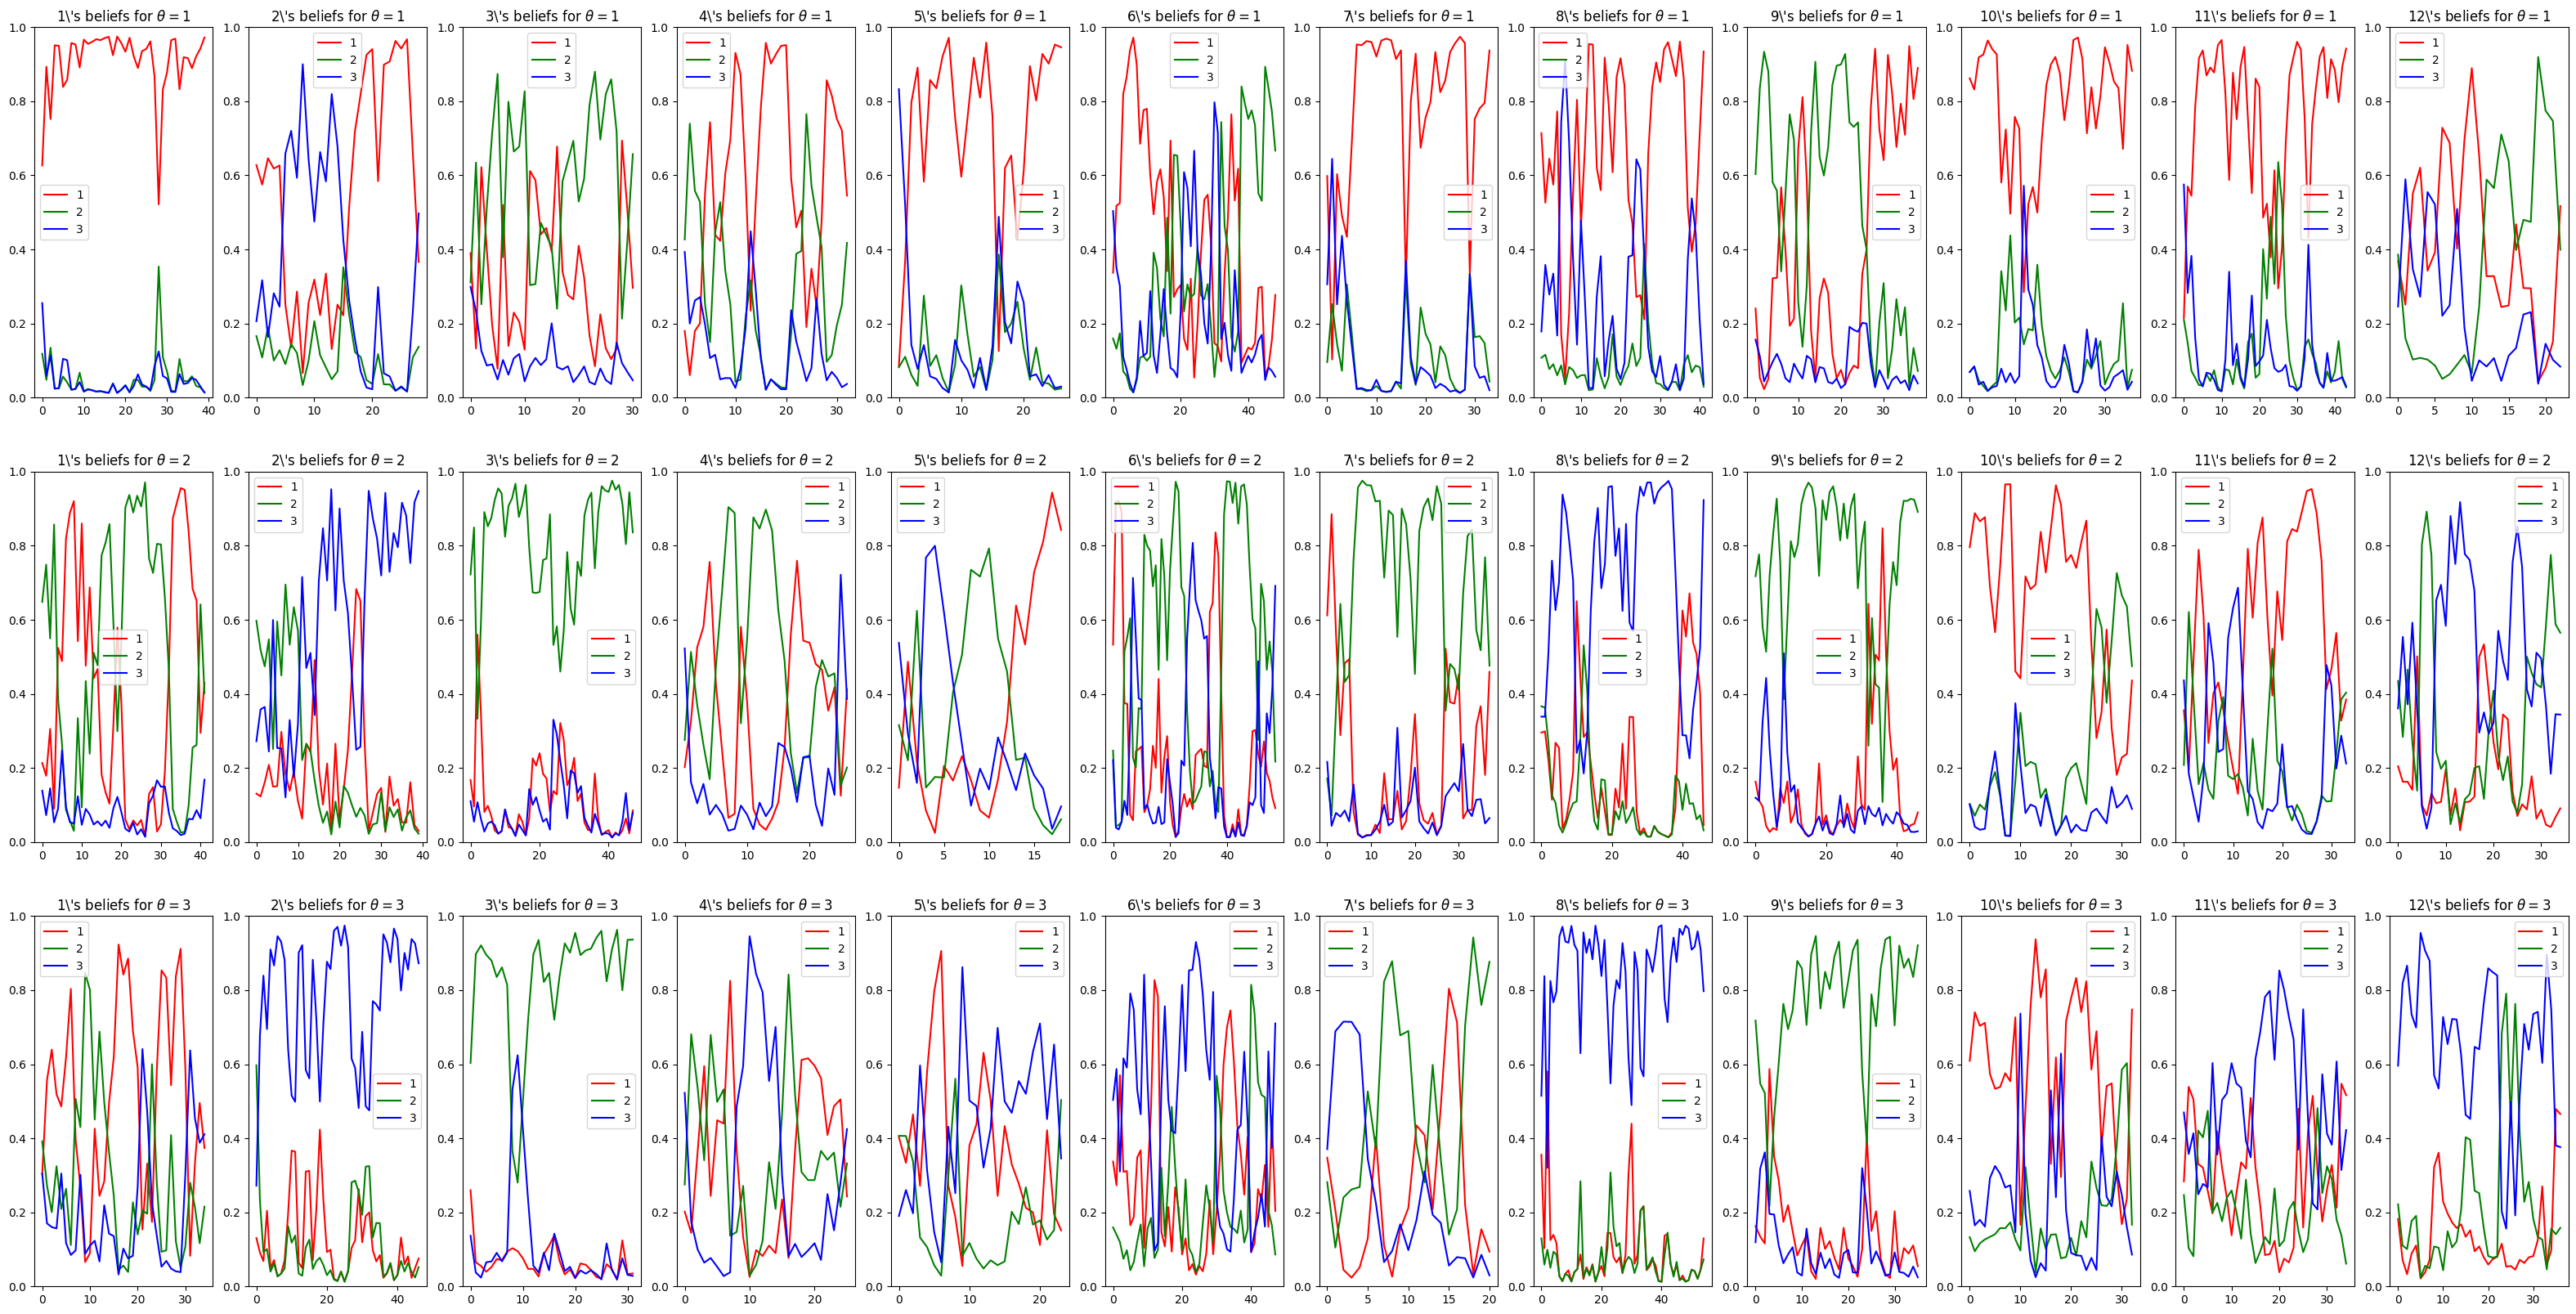

In [55]:
fig, axs = plt.subplots(3, N, figsize=(40, 20))
for m in range(top_n):
    for k in range(N):
        ans = get_bayes_evolution(m, k)
        axs[m][k].plot(ans.mean(axis=0)[:, 0], color='r', label='1')
        axs[m][k].plot(ans.mean(axis=0)[:, 1], color='g', label='2')
        axs[m][k].plot(ans.mean(axis=0)[:, 2], color='b', label='3')
        axs[m][k].set_title(rf"{k+1}\'s beliefs for $\theta=${m+1}")
        axs[m][k].legend()
        axs[m][k].set_ylim([0, 1])